In [1]:
# import intake
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan
import glob
import intake

Get the data

In [2]:
cat = intake.open_catalog("../catalog.yaml")
run = cat.FESOM["tco3999-ng5"]
data = run.original_2d.to_dask()

In [3]:
data

<xarray.Dataset>
Dimensions:   (time: 5400, nod2: 7402886)
Coordinates:
  * time      (time) datetime64[ns] 2020-01-20T00:56:00 ... 2020-08-31T23:56:00
Dimensions without coordinates: nod2
Data variables: (12/19)
    MLD1      (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    MLD2      (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    a_ice     (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    atmice_x  (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    atmice_y  (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    atmoce_x  (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    ...        ...
    ssh       (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    sss       (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    sst       (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    uice      (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    vice      (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
    vve_5     (time, nod2) float32 dask.array<chunksize=(1, 7402886), meta=np.ndarray>
Attributes: (12/16)
    FESOM_model:                         FESOM2
    FESOM_website:                       fesom.de
    FESOM_git_SHA:                       469e74b1
    FESOM_MeshPath:                      /ec/res4/scratch/natr/RAPS/20/inputs...
    FESOM_mesh_representative_checksum:  
    FESOM_ClimateDataPath:               /ec/res4/scratch/natr/RAPS/20/inputs...
    ...                                  ...
    FESOM_include_fleapyear:             -1
    FESOM_use_floatice:                  0
    FESOM_whichEVP:                      1
    FESOM_evp_rheol_steps:               120
    FESOM_opt_visc:                      5
    FESOM_use_wsplit:                    -1

Get the grid

In [4]:
grid = run.node_grid.to_dask()
model_lon_fesom = grid.grid_center_lon.values
model_lat_fesom = grid.grid_center_lat.values
model_lon_fesom = np.where(model_lon_fesom>180, model_lon_fesom-360, model_lon_fesom)
area = grid.cell_area.values.astype('float64')

Get the data

In [17]:
data_sample = data['sst'][0,:].astype('float64')

### Method from Lukas, that is only good if you grid poins all have same size

In [18]:
hist_opts = dict(bins=180, range=(-90, 90))

In [19]:
hist_opts

{'bins': 180, 'range': (-90, 90)}

In [20]:
cells_per_bin, lat_bins = np.histogram(model_lat_fesom, **hist_opts)

In [21]:
varsum_per_bin, bnd = np.histogram(
    model_lat_fesom, weights=data_sample, **hist_opts
)

In [22]:
bnd

array([-90., -89., -88., -87., -86., -85., -84., -83., -82., -81., -80.,
       -79., -78., -77., -76., -75., -74., -73., -72., -71., -70., -69.,
       -68., -67., -66., -65., -64., -63., -62., -61., -60., -59., -58.,
       -57., -56., -55., -54., -53., -52., -51., -50., -49., -48., -47.,
       -46., -45., -44., -43., -42., -41., -40., -39., -38., -37., -36.,
       -35., -34., -33., -32., -31., -30., -29., -28., -27., -26., -25.,
       -24., -23., -22., -21., -20., -19., -18., -17., -16., -15., -14.,
       -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,
        -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,
         9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,
        20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,
        31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,
        42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,
        53.,  54.,  55.,  56.,  57.,  58.,  59.,  6

In [23]:
zonal_mean1 = varsum_per_bin / cells_per_bin

/tmp/ipykernel_3689097/3700803050.py:1: RuntimeWarning: invalid value encountered in true_divide
  zonal_mean1 = varsum_per_bin / cells_per_bin


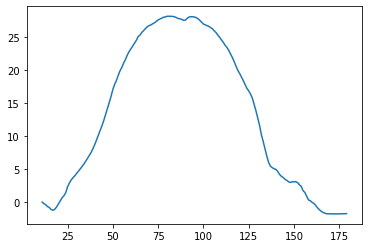

In [24]:
plt.plot(zonal_mean1)

### Area weighted - use, when your grid cells are not the same size :)

In [25]:
varsum_per_bin, _ = np.histogram(
    model_lat_fesom, weights=data_sample*area, **hist_opts
)

In [26]:
area_per_bin, _ = np.histogram(
    model_lat_fesom, weights=area, **hist_opts
)

In [27]:
zonal_mean2 = varsum_per_bin/area_per_bin

/tmp/ipykernel_3689097/3757368940.py:1: RuntimeWarning: invalid value encountered in true_divide
  zonal_mean2 = varsum_per_bin/area_per_bin


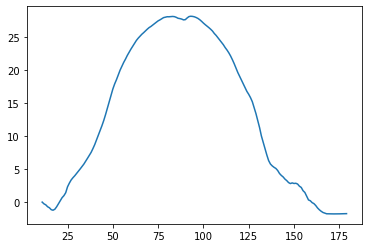

In [28]:
plt.plot(zonal_mean2)